# Optimal Control Problem

The problem then reduces to finding a pair $(\psi, u)$ that minimizes 
$$
J(\psi, u) = \frac{1}{2} \|\psi(\cdot,T) - \psi^\dagger \|_{L^2(R^d)}^2 + \frac{\nu}{2} \int_0^T \|u(t) \|_2^2 \, dt,
$$
where $\psi^\dagger = U^{-1} \rho^\dagger$, subject to the controlled equation
$$
\partial_t \psi = - \mathcal{H} \psi + \sum_{i=1}^m u_i(t) \, \mathcal{N}_i \psi.
$$

In [1]:
import numpy as np
import sympy as sp

from schorodinger_operator import WolframNDEigensystemApproximator
from schorodinger_operator import SchrodingerControlSolver

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Example 1: $V(x) = x^2/2$

We start with the simple example $V(x) = x^2 / 2$, which does not show good properties for our puorposes, but might be interesting. 

In [2]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="0.25*x^2-0.5",
    L=10.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.5}
)

def potential(x): return 0.5 * x**2

def rho_0(x):
    return np.exp(-(x + 2.0)**2 / 2) / np.sqrt(2*np.pi)

def rho_dag(x):
    return np.exp(-x**2 / 2 ) / np.sqrt(2*np.pi)

def nabla_alpha(x):
    return np.ones_like(x)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=rho_dag,
    nu=1e-6,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: x,
    correct_lambda0=True
)

T = 10.0
result_control = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 501), verbose=True, 
                              learning_rate_kwargs={'gamma': 1.1e6})

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 501), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)])

Iteration 1: ||grad|| = 6.100e-06, gamma = 1100000.0
Iteration 2: ||grad|| = 2.954e-07, gamma = 1100000.0
Iteration 3: ||grad|| = 2.524e-07, gamma = 1100000.0
Iteration 4: ||grad|| = 5.654e-08, gamma = 1100000.0
Iteration 5: ||grad|| = 2.626e-08, gamma = 1100000.0
Iteration 6: ||grad|| = 8.719e-09, gamma = 1100000.0
Iteration 7: ||grad|| = 2.670e-09, gamma = 1100000.0
Iteration 8: ||grad|| = 8.046e-10, gamma = 1100000.0
Iteration 9: ||grad|| = 2.413e-10, gamma = 1100000.0
Iteration 10: ||grad|| = 7.241e-11, gamma = 1100000.0


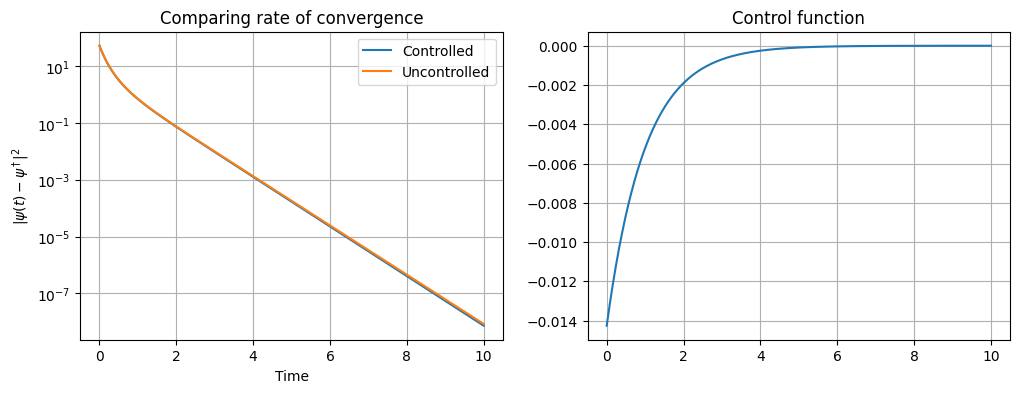

In [3]:
time_grid = result['time']
u_vals = result_control['u_vals'][:, 0]

diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time_grid, diff_control, label='Controlled')
ax[0].plot(time_grid, diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(time_grid, u_vals)
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

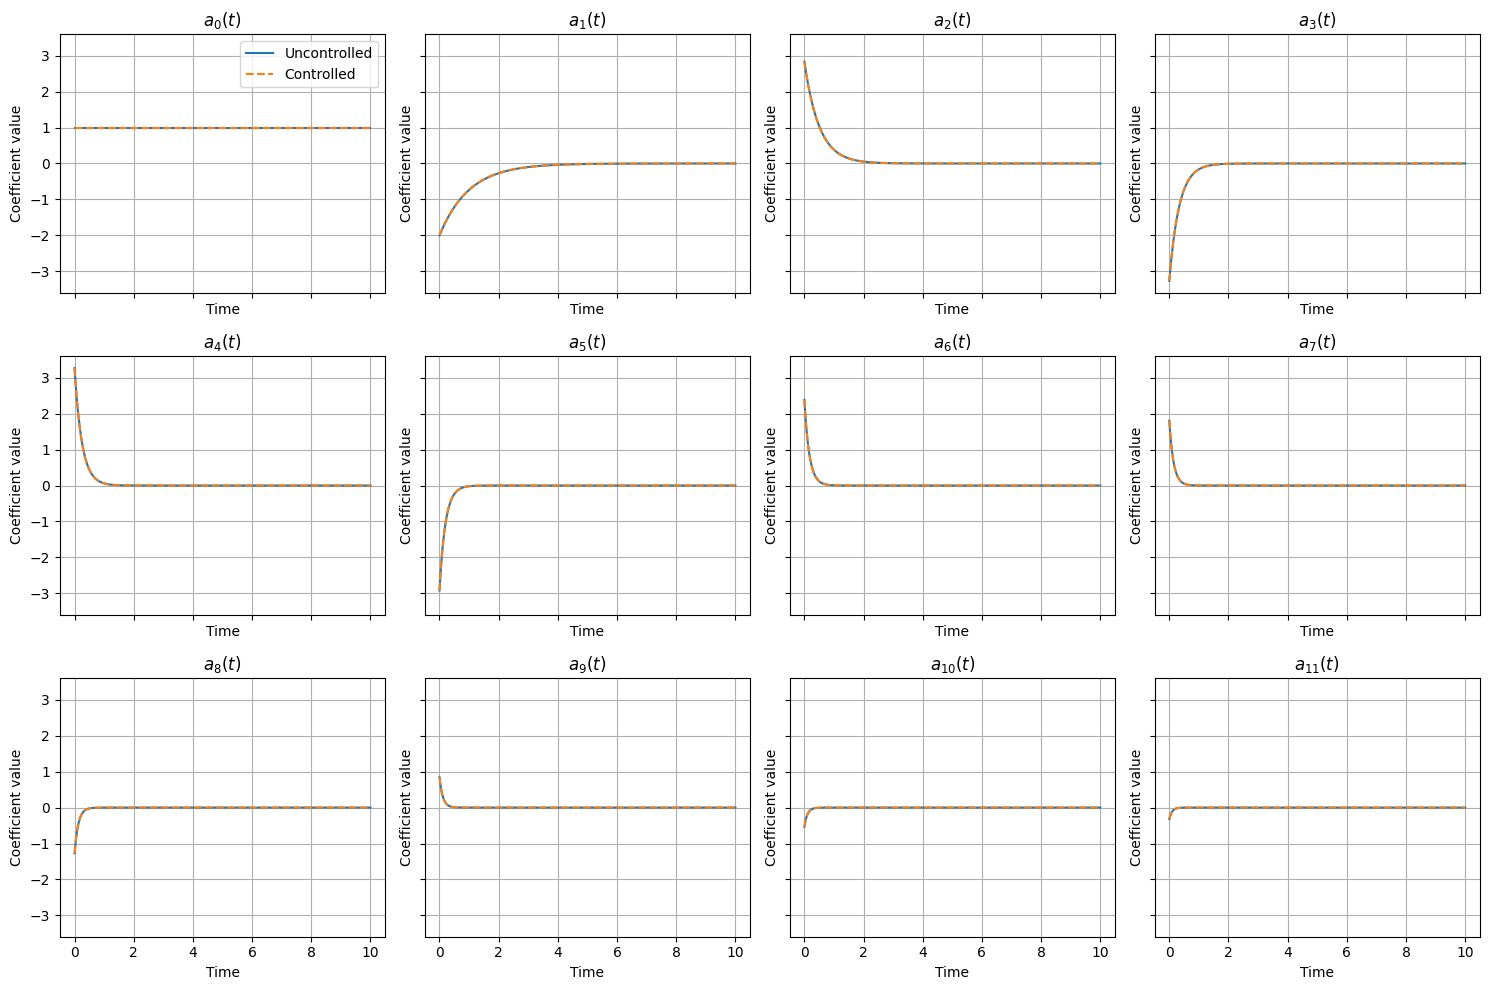

In [4]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(time_grid, result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(time_grid, result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 2: $V(x) = (x^2 - 1.5)^2$

In this example, I chose $\alpha$ "smartly".

In [5]:
x = sp.symbols('x')
potential = (x**2 - 1.5)**2

potential_prime = sp.diff(potential, x)
potential_double_prime = sp.diff(potential_prime, x)

expression = 0.25 * potential_prime**2 - 0.5 * potential_double_prime
print(expression.simplify())

4.0*x**6 - 12.0*x**4 + 3.0*x**2 + 3.0


In [108]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    nu=1e-6,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 1.0
result_control = solver.solve(T=T, max_iter=50, tol=1e-8, time_eval=np.linspace(0, T, 1001), verbose=True,
                              #learning_rate_kwargs={'method': 'backtracking', 'gamma_init': 100, 'alpha': 0.8, 'beta': 0.9},
                              learning_rate_kwargs={'gamma': 120}
                             )

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 1001), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)])

Iteration 1: ||grad|| = 8.881e-01, gamma = 120
Iteration 2: ||grad|| = 9.241e-01, gamma = 120
Iteration 3: ||grad|| = 9.844e-01, gamma = 120
Iteration 4: ||grad|| = 1.023e+00, gamma = 120
Iteration 5: ||grad|| = 9.276e-01, gamma = 120
Iteration 6: ||grad|| = 7.046e-01, gamma = 120
Iteration 7: ||grad|| = 6.750e-01, gamma = 120
Iteration 8: ||grad|| = 6.583e-01, gamma = 120
Iteration 9: ||grad|| = 7.069e-01, gamma = 120
Iteration 10: ||grad|| = 6.700e-01, gamma = 120
Iteration 11: ||grad|| = 5.369e-01, gamma = 120
Iteration 12: ||grad|| = 5.198e-01, gamma = 120
Iteration 13: ||grad|| = 5.467e-01, gamma = 120
Iteration 14: ||grad|| = 5.147e-01, gamma = 120
Iteration 15: ||grad|| = 4.611e-01, gamma = 120
Iteration 16: ||grad|| = 4.516e-01, gamma = 120
Iteration 17: ||grad|| = 4.531e-01, gamma = 120
Iteration 18: ||grad|| = 4.105e-01, gamma = 120
Iteration 19: ||grad|| = 4.194e-01, gamma = 120
Iteration 20: ||grad|| = 4.249e-01, gamma = 120
Iteration 21: ||grad|| = 3.856e-01, gamma = 120
I

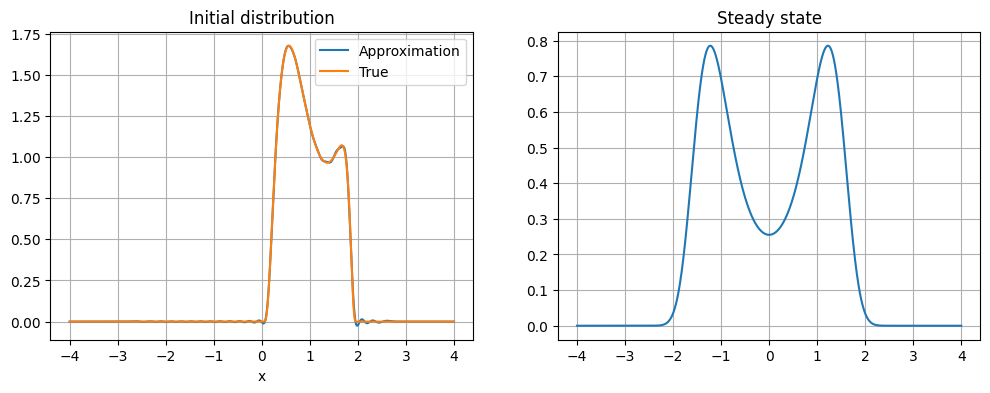

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(solver.x, result['psi'][0,:], label='Approximation')
ax[0].plot(solver.x, rho_0(solver.x) / np.sqrt(solver.rho_infty(solver.x)), label='True')

ax[0].set_xlabel('x')
ax[0].set_title('Initial distribution')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(solver.x, np.sqrt(solver.rho_infty(solver.x)))
ax[1].grid(True)
ax[1].set_title("Steady state")

plt.show()

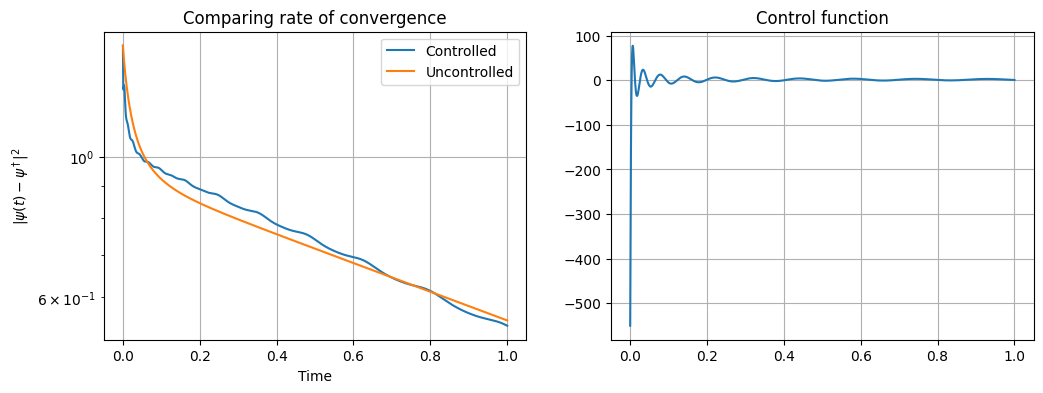

In [110]:
diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

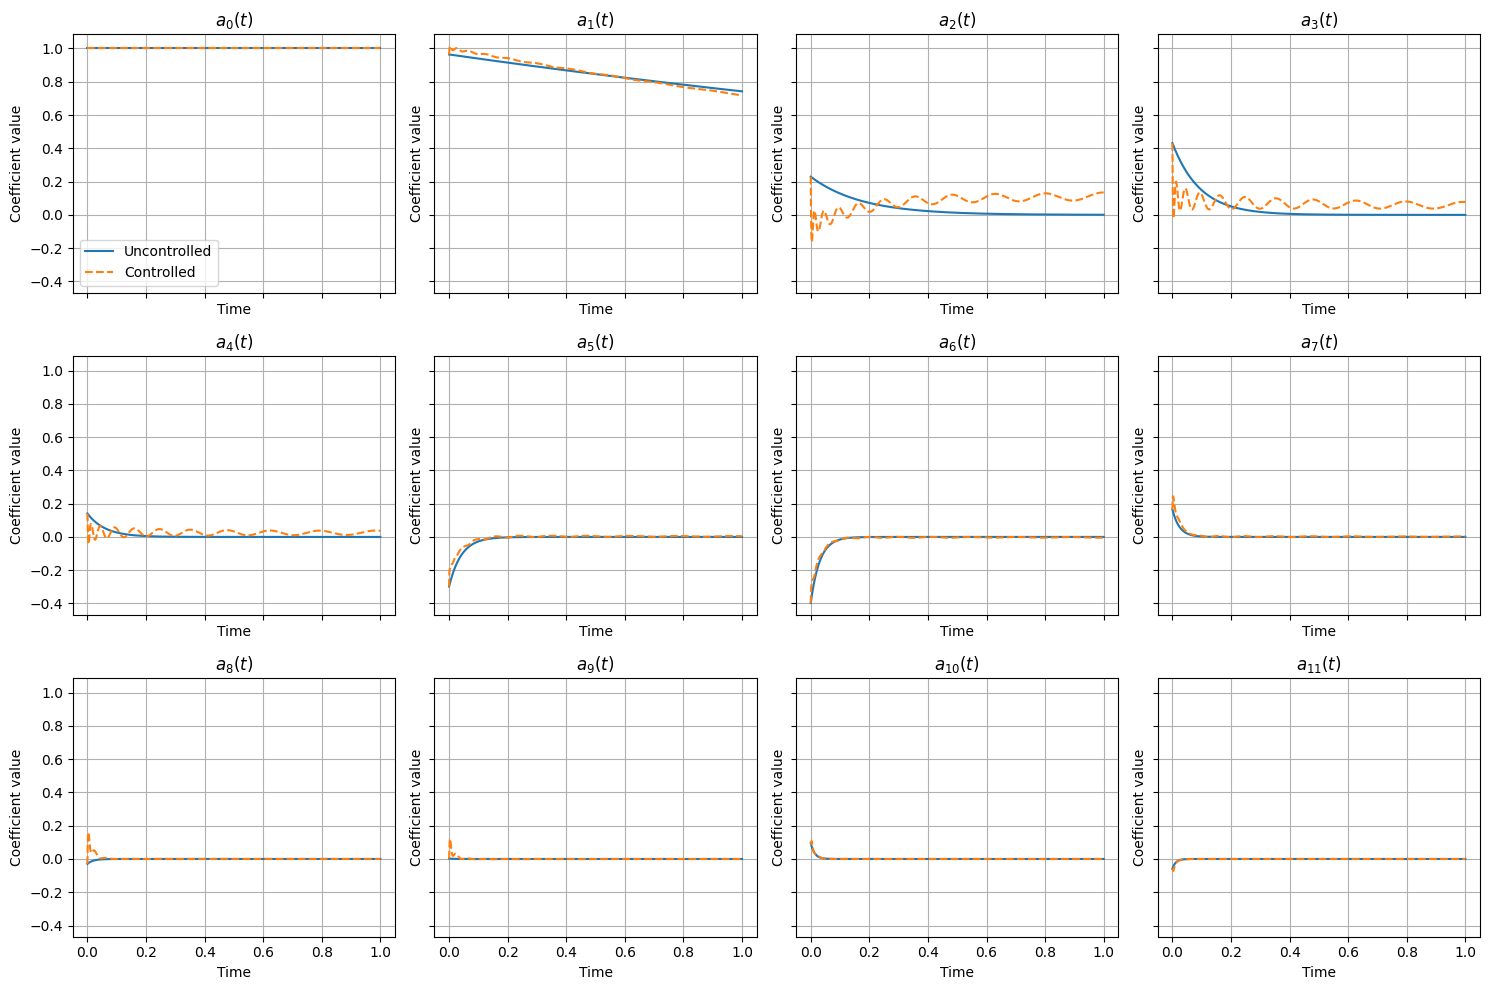

In [111]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

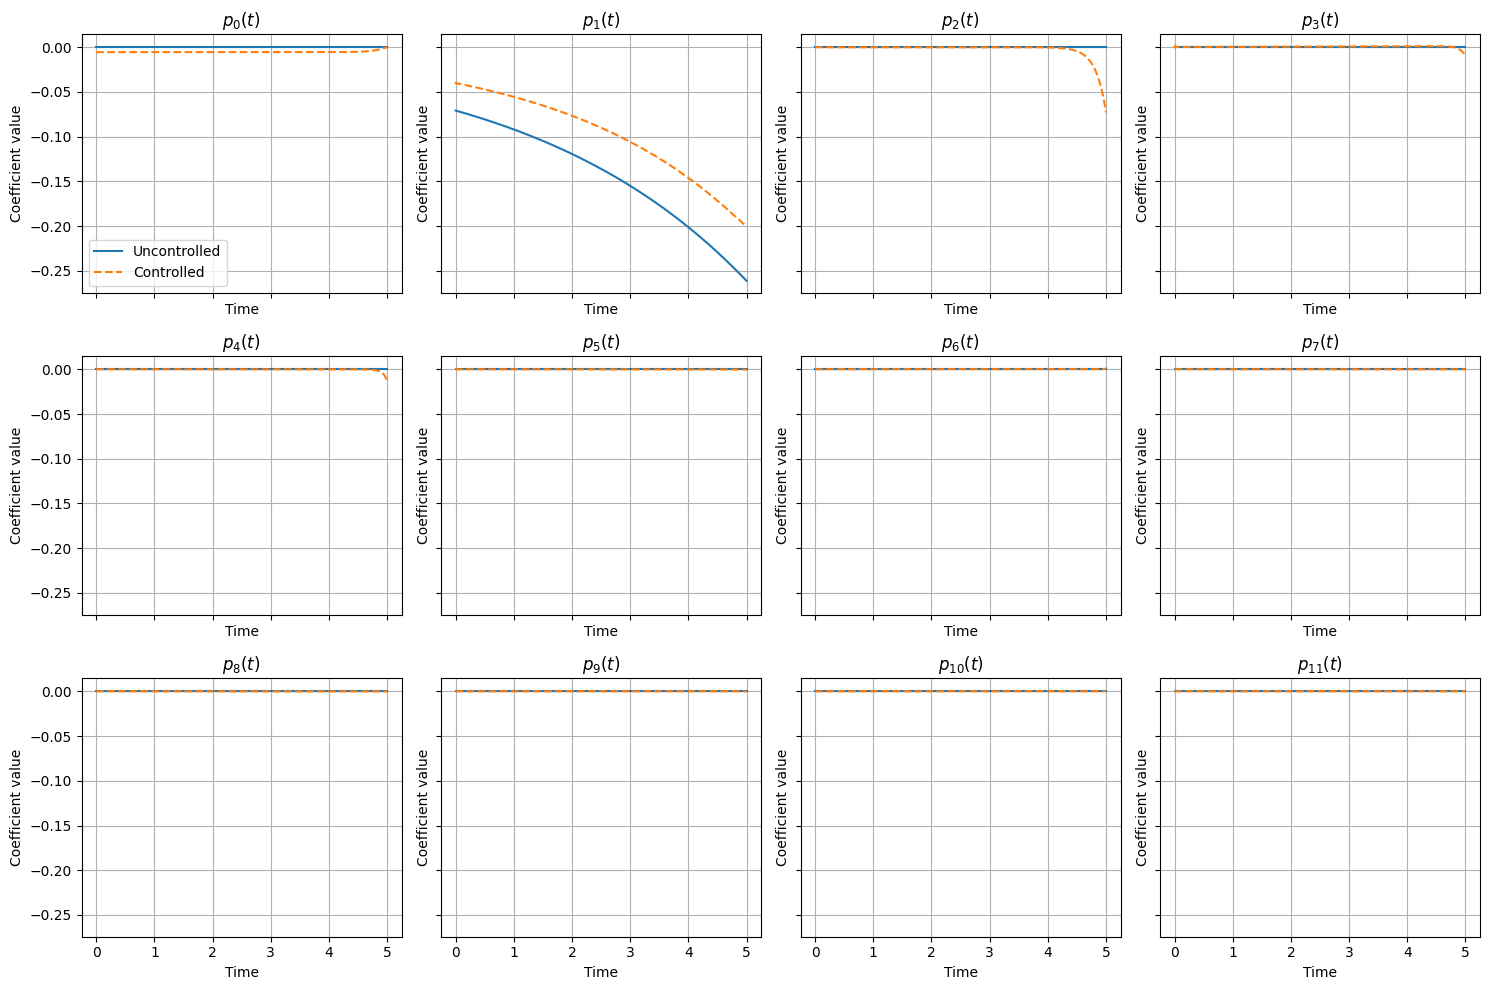

In [10]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['p_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$p_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

### Checking what could be going wrong

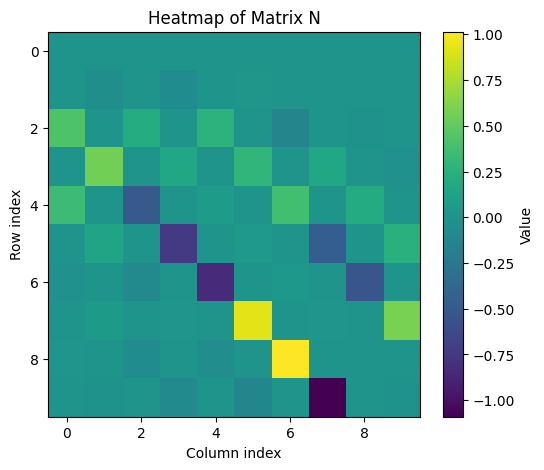

In [11]:
plt.figure(figsize=(6, 5))
plt.imshow(solver.Delta[0][:10,:10], cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('Heatmap of Matrix N')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.show()

## Example 3: $V(x) = (x^2 - 1.5)^2$

Let's choose $\alpha$ in a trivial way, uniform.

In [19]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.ones_like(x)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    nu=1e-6,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control = solver.solve(T=T, max_iter=1000, tol=1e-8, time_eval=np.linspace(0, T, 1001), verbose=True,
                              #learning_rate_kwargs={'method': 'backtracking', 'gamma_init': 100, 'alpha': 0.8, 'beta': 0.9},
                              learning_rate_kwargs={'gamma': 22}
                             )

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 1001), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)])

Iteration 1: ||grad|| = 1.351e-01, gamma = 22
Iteration 2: ||grad|| = 1.959e-01, gamma = 22
Iteration 3: ||grad|| = 2.630e-01, gamma = 22
Iteration 4: ||grad|| = 1.245e-01, gamma = 22
Iteration 5: ||grad|| = 1.201e-01, gamma = 22
Iteration 6: ||grad|| = 9.672e-02, gamma = 22
Iteration 7: ||grad|| = 9.238e-02, gamma = 22
Iteration 8: ||grad|| = 8.038e-02, gamma = 22
Iteration 9: ||grad|| = 7.939e-02, gamma = 22
Iteration 10: ||grad|| = 7.192e-02, gamma = 22
Iteration 11: ||grad|| = 7.203e-02, gamma = 22
Iteration 12: ||grad|| = 6.668e-02, gamma = 22
Iteration 13: ||grad|| = 6.714e-02, gamma = 22
Iteration 14: ||grad|| = 6.295e-02, gamma = 22
Iteration 15: ||grad|| = 6.356e-02, gamma = 22
Iteration 16: ||grad|| = 6.011e-02, gamma = 22
Iteration 17: ||grad|| = 6.079e-02, gamma = 22
Iteration 18: ||grad|| = 5.784e-02, gamma = 22
Iteration 19: ||grad|| = 5.857e-02, gamma = 22
Iteration 20: ||grad|| = 5.595e-02, gamma = 22
Iteration 21: ||grad|| = 5.670e-02, gamma = 22
Iteration 22: ||grad||

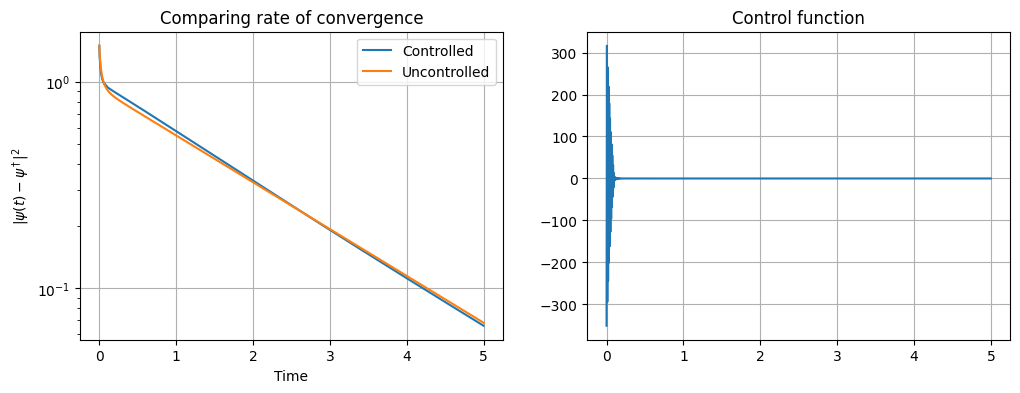

In [20]:
diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

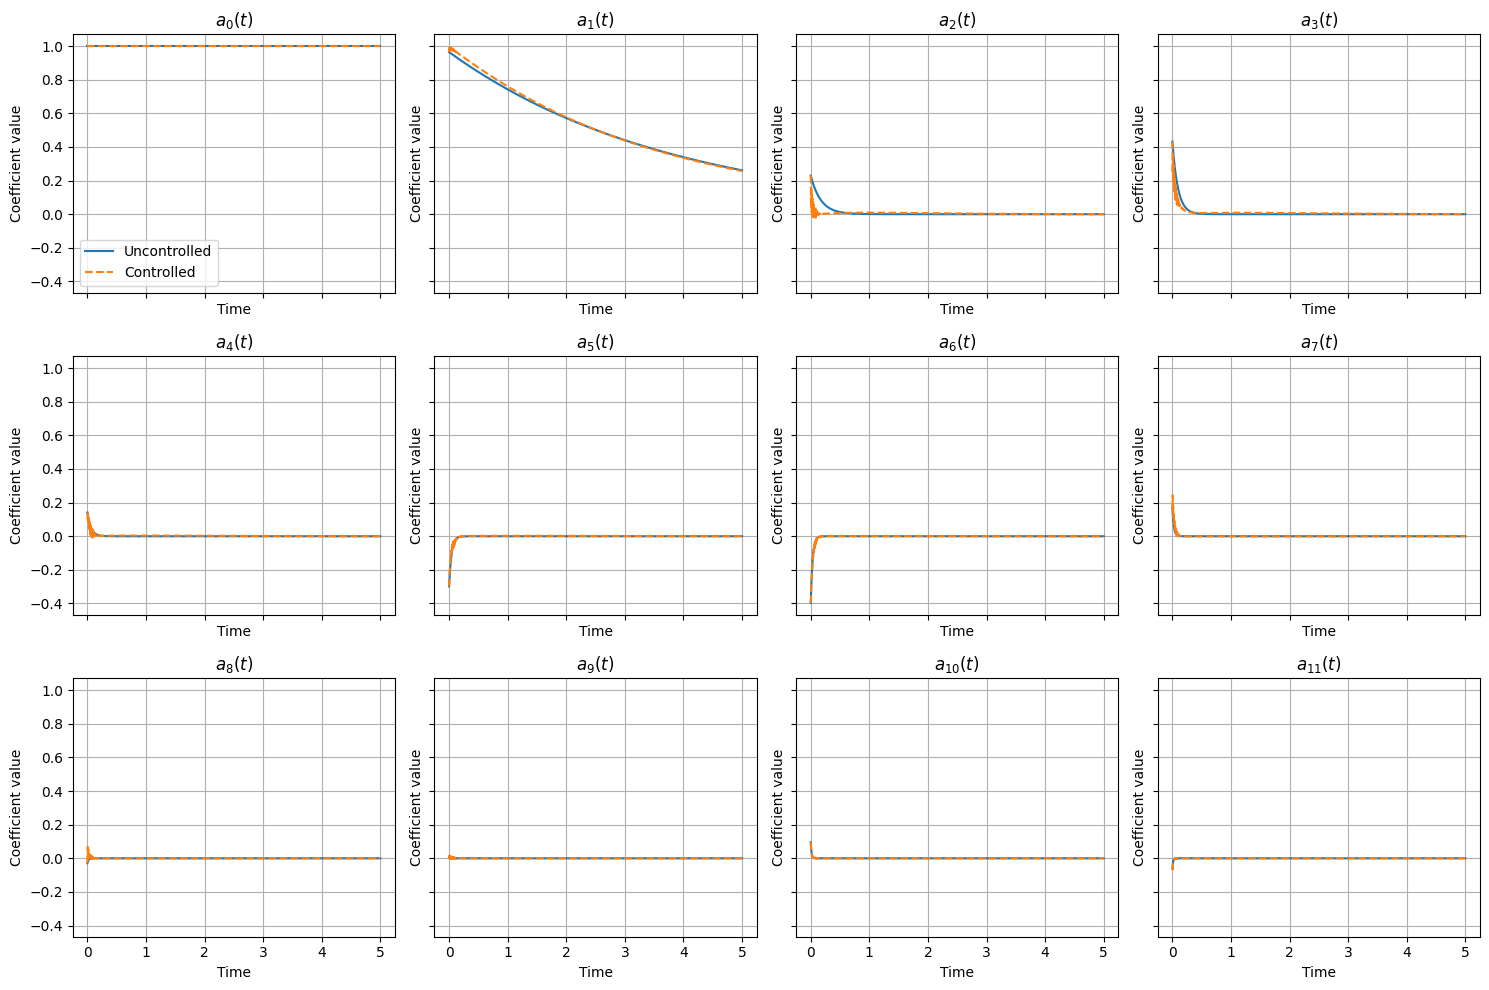

In [21]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 4: $V(x) = (x^2 - 1.5)^2$

Let's include a penalisation $e^{-\lambda t}$ in the control.

In [58]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    nu=1e-6,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control = solver.solve(T=T, max_iter=100, tol=1e-8, time_eval=np.linspace(0, T, 1001), verbose=True,
                              #learning_rate_kwargs={'method': 'backtracking', 'gamma_init': 100, 'alpha': 0.8, 'beta': 0.9},
                              learning_rate_kwargs={'gamma': 500, 'lambda': 10}
                             )

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 1001), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)])

Iteration 1: ||grad|| = 1.021e-01, gamma = 500
Iteration 2: ||grad|| = 5.428e-02, gamma = 500
Iteration 3: ||grad|| = 2.349e-02, gamma = 500
Iteration 4: ||grad|| = 1.528e-02, gamma = 500
Iteration 5: ||grad|| = 1.428e-02, gamma = 500
Iteration 6: ||grad|| = 1.362e-02, gamma = 500
Iteration 7: ||grad|| = 1.317e-02, gamma = 500
Iteration 8: ||grad|| = 1.279e-02, gamma = 500
Iteration 9: ||grad|| = 1.249e-02, gamma = 500
Iteration 10: ||grad|| = 1.222e-02, gamma = 500
Iteration 11: ||grad|| = 1.200e-02, gamma = 500
Iteration 12: ||grad|| = 1.180e-02, gamma = 500
Iteration 13: ||grad|| = 1.163e-02, gamma = 500
Iteration 14: ||grad|| = 1.148e-02, gamma = 500
Iteration 15: ||grad|| = 1.134e-02, gamma = 500
Iteration 16: ||grad|| = 1.122e-02, gamma = 500
Iteration 17: ||grad|| = 1.111e-02, gamma = 500
Iteration 18: ||grad|| = 1.101e-02, gamma = 500
Iteration 19: ||grad|| = 1.092e-02, gamma = 500
Iteration 20: ||grad|| = 1.083e-02, gamma = 500
Iteration 21: ||grad|| = 1.076e-02, gamma = 500
I

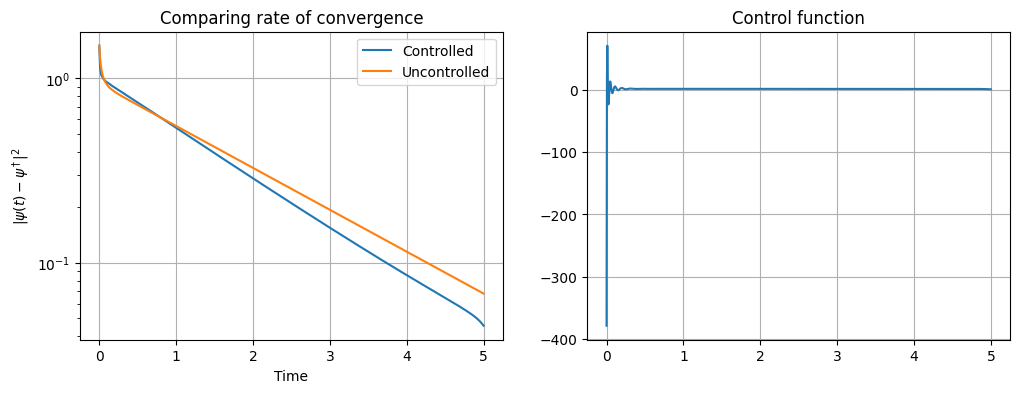

In [59]:
diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

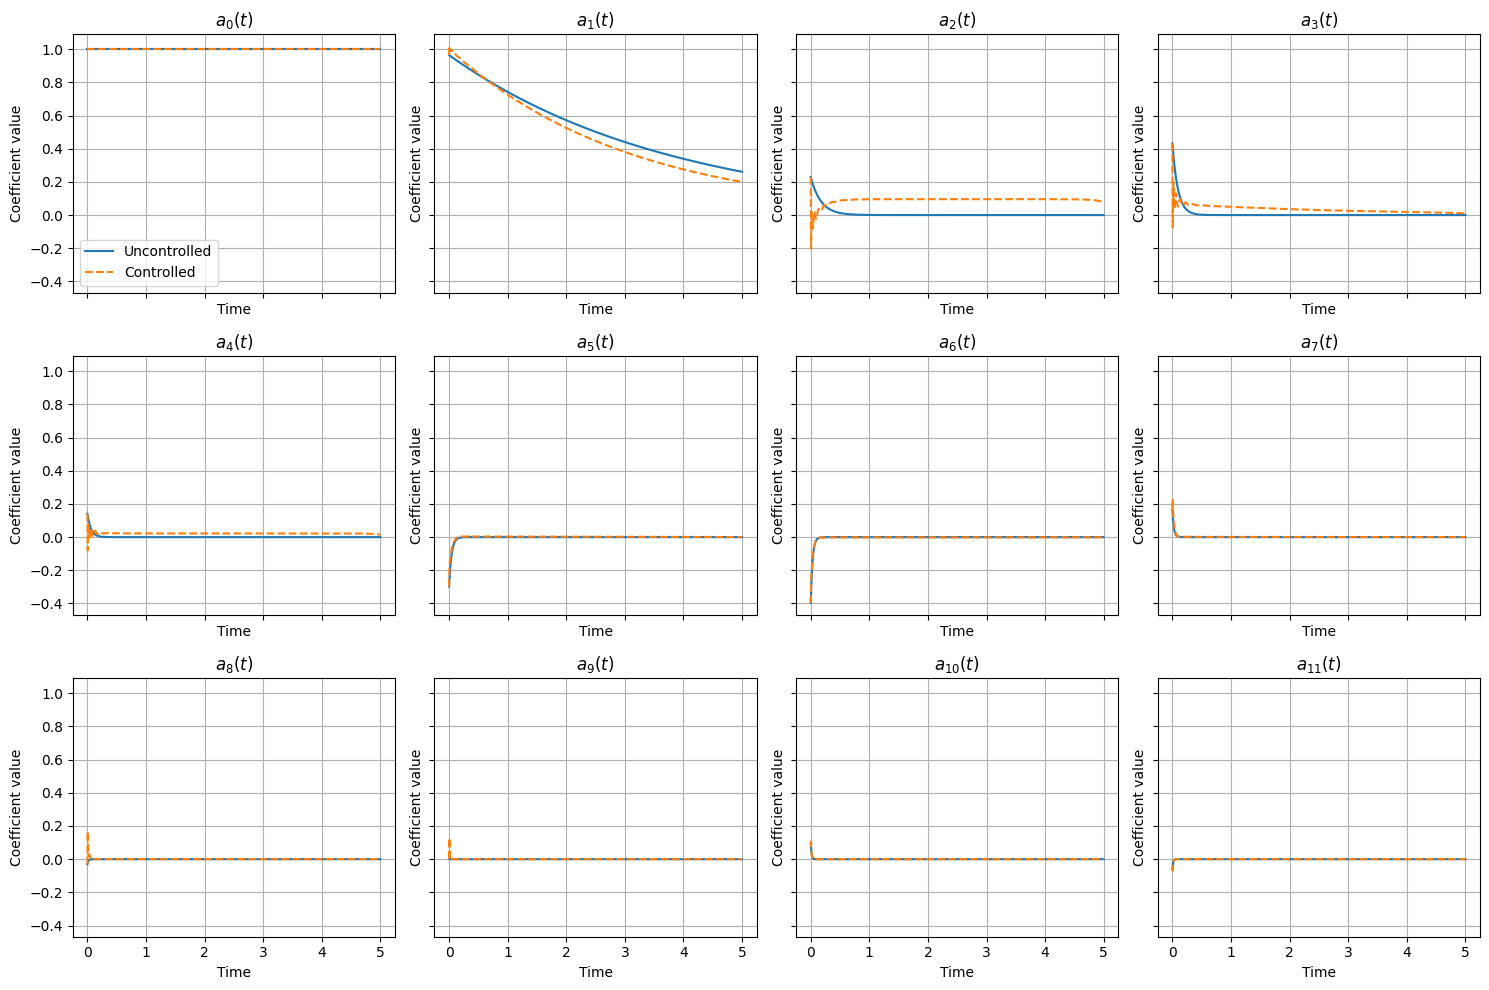

In [62]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 5: $V(x) = (x^2 - 1.5)^2$

Let's include a penalisation $\kappa / 2 ||\psi(\cdot, t) - \psi^\dagger||^2$ in the objective.

In [78]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    nu=1e-6,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control = solver.solve(T=T, max_iter=100, tol=1e-8, time_eval=np.linspace(0, T, 1001), verbose=True,
                              #learning_rate_kwargs={'method': 'backtracking', 'gamma_init': 100, 'alpha': 0.8, 'beta': 0.9},
                              learning_rate_kwargs={'gamma': 6, 'lambda': 0}, kappa=10
                             )

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 1001), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)])

Iteration 1: ||grad|| = 1.151e+01, gamma = 6
Iteration 2: ||grad|| = 1.145e+01, gamma = 6
Iteration 3: ||grad|| = 1.124e+01, gamma = 6
Iteration 4: ||grad|| = 1.158e+01, gamma = 6
Iteration 5: ||grad|| = 1.140e+01, gamma = 6
Iteration 6: ||grad|| = 1.169e+01, gamma = 6
Iteration 7: ||grad|| = 1.065e+01, gamma = 6
Iteration 8: ||grad|| = 1.017e+01, gamma = 6
Iteration 9: ||grad|| = 9.683e+00, gamma = 6
Iteration 10: ||grad|| = 9.331e+00, gamma = 6
Iteration 11: ||grad|| = 8.991e+00, gamma = 6
Iteration 12: ||grad|| = 8.752e+00, gamma = 6
Iteration 13: ||grad|| = 8.484e+00, gamma = 6
Iteration 14: ||grad|| = 8.281e+00, gamma = 6
Iteration 15: ||grad|| = 8.103e+00, gamma = 6
Iteration 16: ||grad|| = 7.949e+00, gamma = 6
Iteration 17: ||grad|| = 7.804e+00, gamma = 6
Iteration 18: ||grad|| = 7.678e+00, gamma = 6
Iteration 19: ||grad|| = 7.564e+00, gamma = 6
Iteration 20: ||grad|| = 7.461e+00, gamma = 6
Iteration 21: ||grad|| = 7.367e+00, gamma = 6
Iteration 22: ||grad|| = 7.281e+00, gamma =

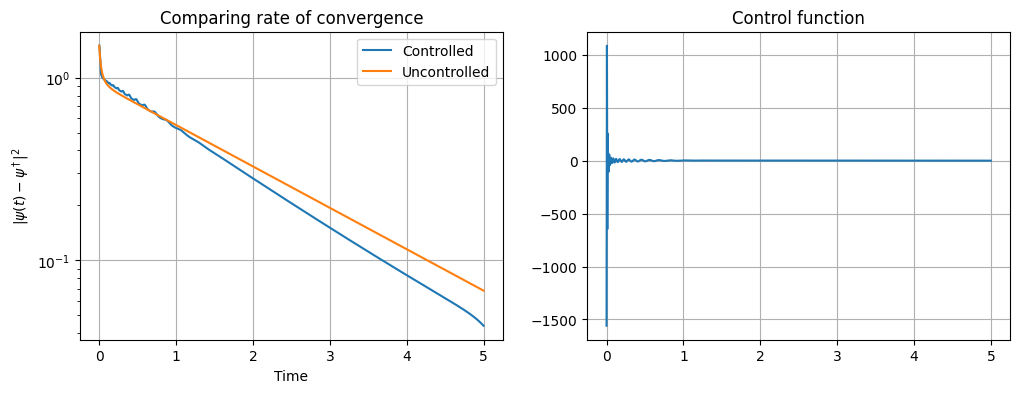

In [79]:
diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

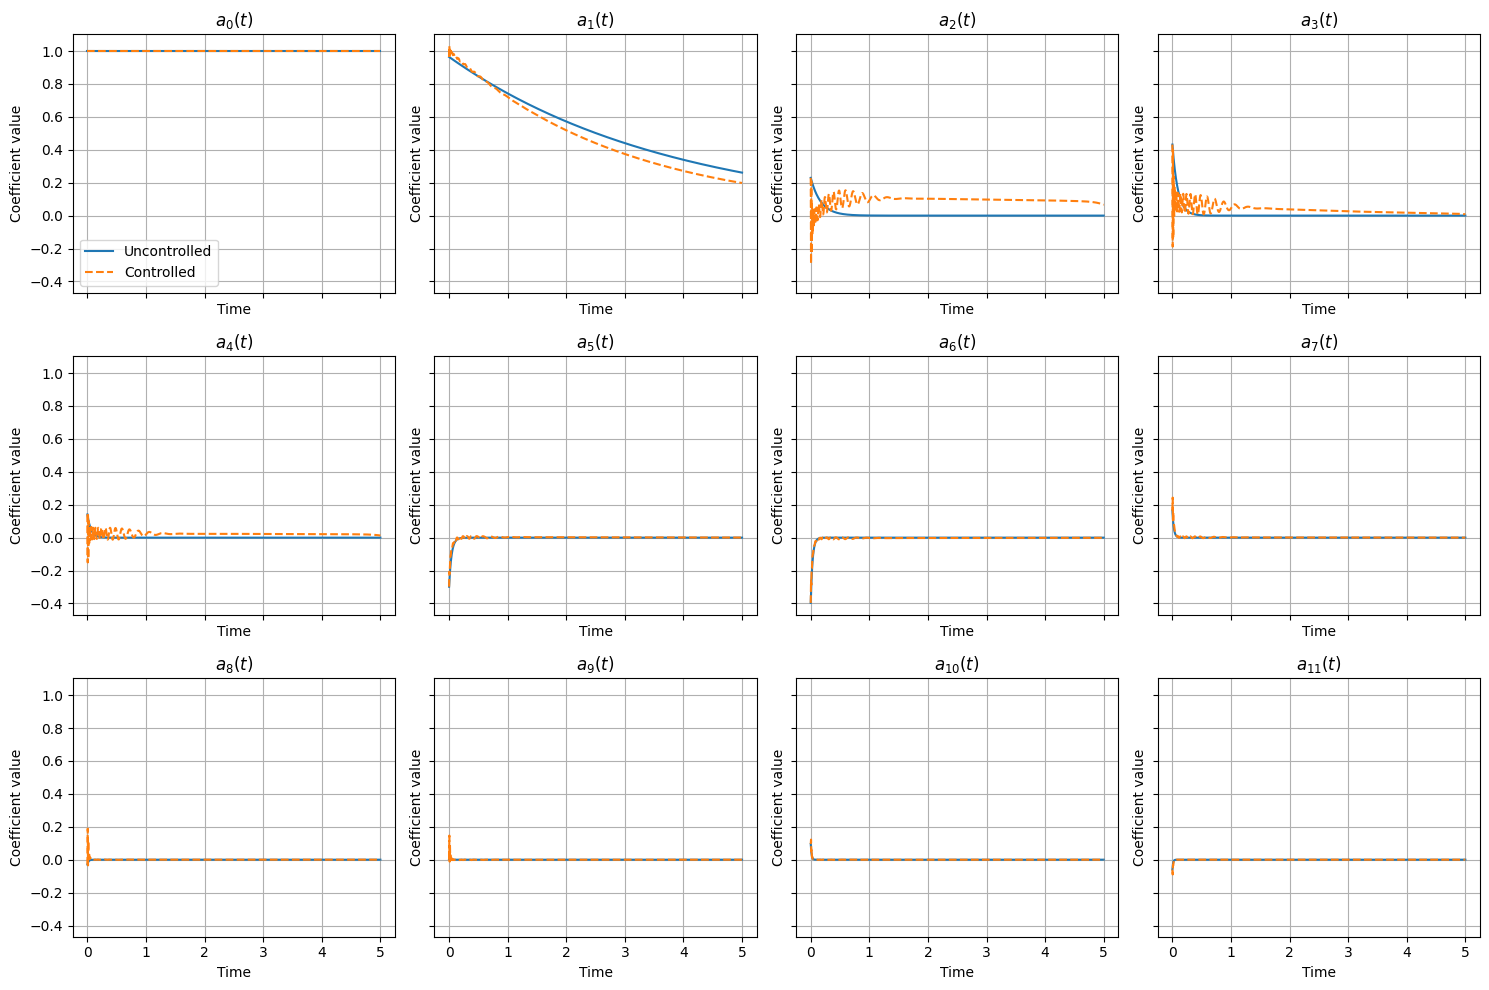

In [80]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 6

Same thing as before...

In [101]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2
time_eval = np.linspace(0, T, 1001)

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    nu=1e-6,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 10.0
result_control = solver.solve(T=T, max_iter=200, tol=1e-8, time_eval=time_eval, verbose=True,
                              old_u_discrete = 1e2*np.exp(-5 * time_eval)[:, None] * np.ones((1, 1)),
                              learning_rate_kwargs={'method': 'backtracking', 'gamma_init': 200, 'alpha': 0.9, 'beta': 0.9},
                              #learning_rate_kwargs={'gamma': 150}
                             )

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 1001), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)])

Iteration 1: ||grad|| = 2.774e-02, gamma = 200
Iteration 2: ||grad|| = 1.631e-03, gamma = 200
Iteration 3: ||grad|| = 1.627e-03, gamma = 200
Iteration 4: ||grad|| = 1.622e-03, gamma = 200
Iteration 5: ||grad|| = 1.618e-03, gamma = 200
Iteration 6: ||grad|| = 1.613e-03, gamma = 200
Iteration 7: ||grad|| = 1.609e-03, gamma = 200
Iteration 8: ||grad|| = 1.605e-03, gamma = 200
Iteration 9: ||grad|| = 1.600e-03, gamma = 200
Iteration 10: ||grad|| = 1.596e-03, gamma = 200
Iteration 11: ||grad|| = 1.592e-03, gamma = 200
Iteration 12: ||grad|| = 1.587e-03, gamma = 200
Iteration 13: ||grad|| = 1.583e-03, gamma = 200
Iteration 14: ||grad|| = 1.579e-03, gamma = 200
Iteration 15: ||grad|| = 1.575e-03, gamma = 200
Iteration 16: ||grad|| = 1.571e-03, gamma = 200
Iteration 17: ||grad|| = 1.567e-03, gamma = 200
Iteration 18: ||grad|| = 1.562e-03, gamma = 200
Iteration 19: ||grad|| = 1.558e-03, gamma = 200
Iteration 20: ||grad|| = 1.554e-03, gamma = 200
Iteration 21: ||grad|| = 1.550e-03, gamma = 200
I

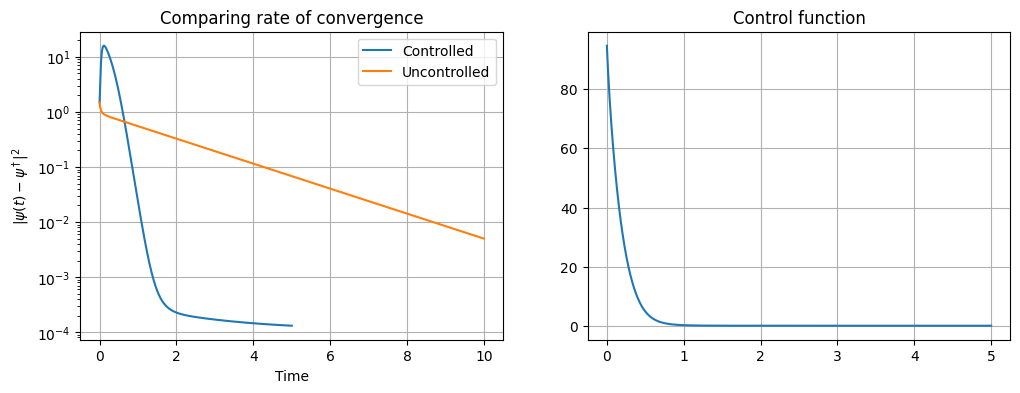

In [102]:
diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

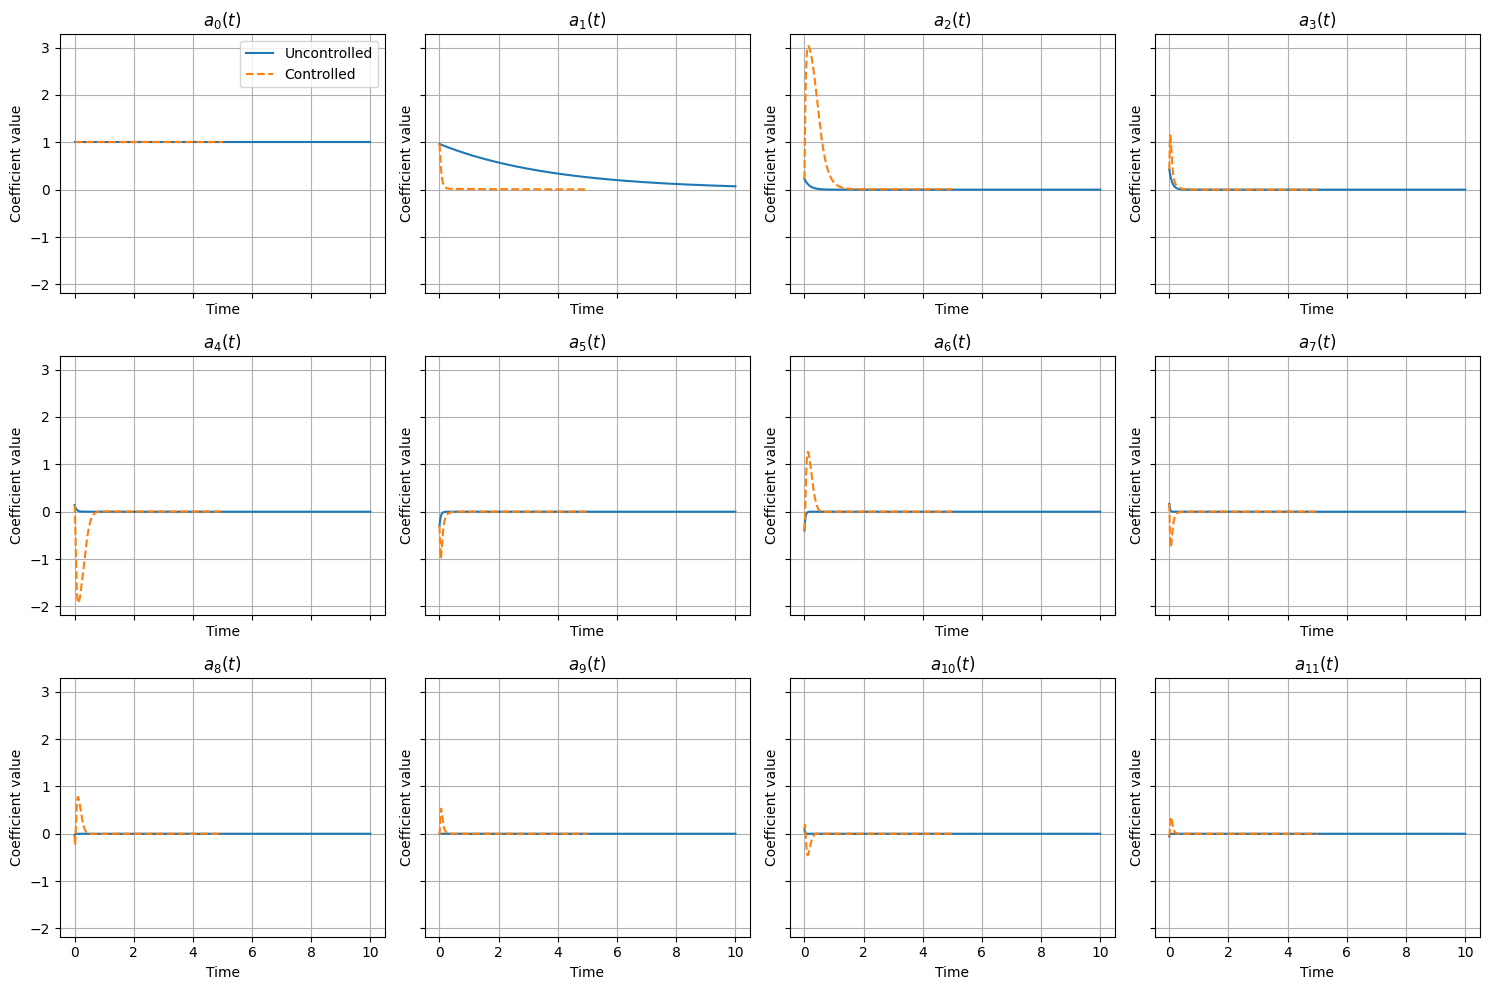

In [103]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()